In [20]:
# 📦 1. 載入必要套件
import os
import random
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torchvision import datasets, transforms, models
import torch
from sklearn.manifold import TSNE

In [3]:
# 📂 2. 載入資料集
DATA_DIR = 'data/train'
dataset = datasets.ImageFolder(DATA_DIR)

In [4]:
# 🧾 3. 查看類別名稱與對應 label
print("類別名稱：", dataset.classes)
print("label 對應：", dataset.class_to_idx)

類別名稱： ['0_spaghetti', '1_ramen', '2_udon']
label 對應： {'0_spaghetti': 0, '1_ramen': 1, '2_udon': 2}


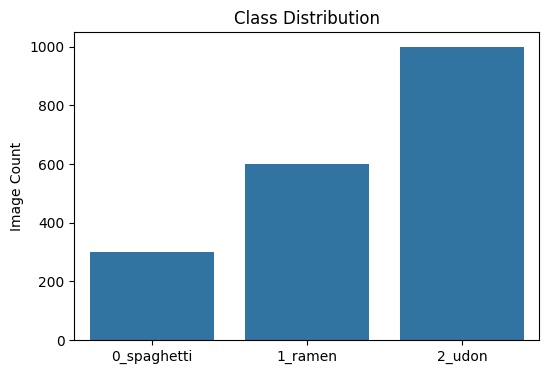

In [8]:
# 📊 4. 類別分布統計
labels = [label for _, label in dataset]
counts = Counter(labels)
label_names = dataset.classes

plt.figure(figsize=(6, 4))
sns.barplot(x=label_names, y=[counts[i] for i in range(len(label_names))])
plt.title("Class Distribution")
plt.ylabel("Image Count")
plt.show()

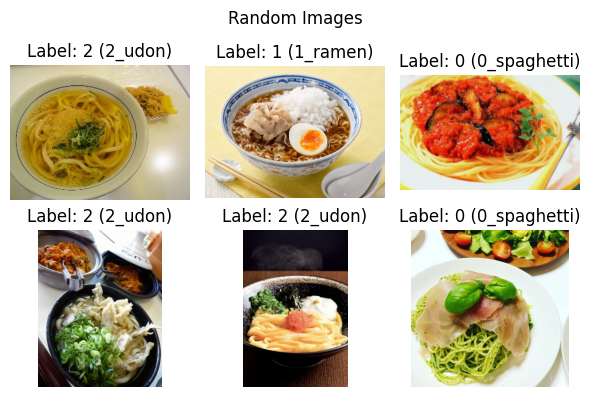

In [12]:
# 🖼️ 5. 顯示隨機圖片
plt.figure(figsize=(6, 4))
for i in range(6):
    path, label = random.choice(dataset.samples)
    img = Image.open(path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label} ({label_names[label]})")
    plt.axis("off")
plt.suptitle("Random Images")
plt.tight_layout()
plt.show()

In [13]:
# 📐 6. 圖片大小統計
sizes = []
for path, _ in dataset.samples:
    img = Image.open(path)
    sizes.append(img.size)

size_df = pd.DataFrame(sizes, columns=["width", "height"])
print(size_df.describe())

             width       height
count  1900.000000  1900.000000
mean    287.853158   236.924737
std      30.538661    43.774930
min     135.000000   117.000000
25%     300.000000   200.000000
50%     300.000000   225.000000
75%     300.000000   300.000000
max     300.000000   300.000000


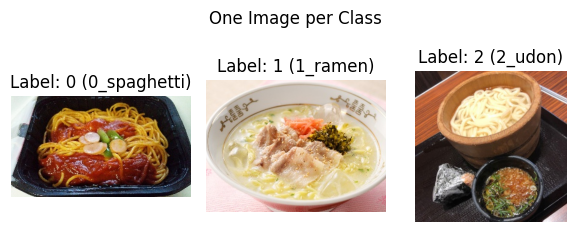

In [14]:
# （可選）7. 每類別各顯示一張
plt.figure(figsize=(6, 4))
for i, class_name in enumerate(label_names):
    path, label = random.choice(dataset.samples)
    while label != i:
        path, label = random.choice(dataset.samples)
    img = Image.open(path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label} ({class_name})")
    plt.axis("off")
plt.suptitle("One Image per Class")
plt.tight_layout()
plt.show()

📌 8. 視覺風格一致性分析

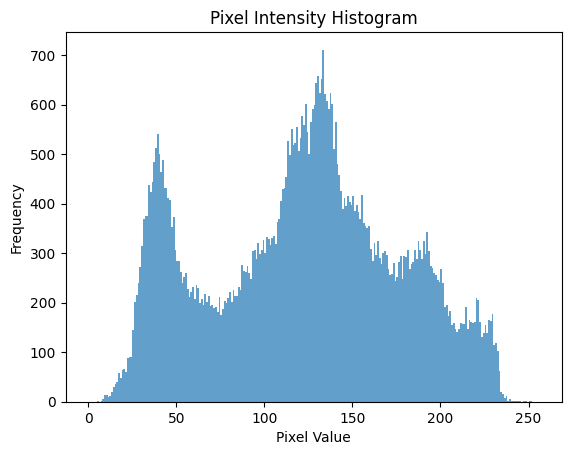

In [15]:
# 方法一：Pixel Intensity Histogram（灰階強度分布）
# 👉 檢查圖片整體亮度與對比度是否一致，例如是否有過暗或過亮的圖片

img_path = random.choice(dataset.samples)[0]
gray_img = Image.open(img_path).convert("L")
plt.hist(gray_img.getdata(), bins=256, range=[0, 256], alpha=0.7)
plt.title("Pixel Intensity Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

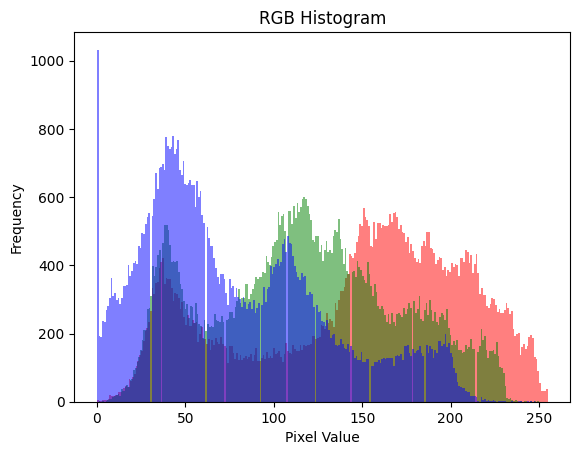

In [ ]:
# 方法二：RGB Histogram（每個顏色頻率分布）
# 👉 分別觀察 R/G/B 三個通道的顏色分布，用來比較圖片是否偏紅/偏綠等

img = Image.open(img_path).convert("RGB")
arr = np.array(img)
colors = ('r', 'g', 'b')
for i, color in enumerate(colors):
    plt.hist(arr[..., i].flatten(), bins=256, alpha=0.5, color=color)
plt.title("RGB Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


/home/ubuntu/projects/deep-learning/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/projects/deep-learning/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


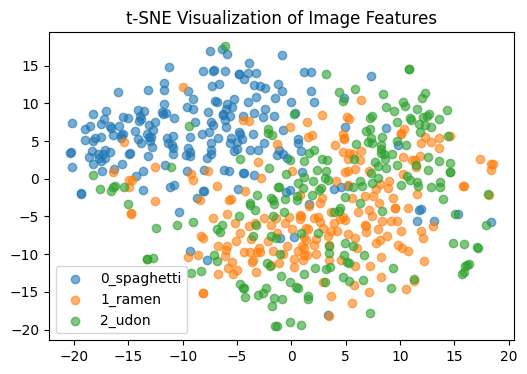

In [25]:
# 方法三：t-SNE 視覺語意特徵降維（使用 ResNet18 特徵）
# 👉 把每張圖片餵進 ResNet18 的 CNN 模型，抽取語意特徵向量（不含分類頭）
# 👉 接著使用 t-SNE 將高維特徵降維成 2 維，觀察類別在視覺語意空間的聚集情況
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # 移除分類層
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

features = []
labels = []
from collections import defaultdict

features = []
labels = []
per_class = 200  # 每類抽樣 200 張，總共約 600 張
class_samples = defaultdict(list)

# 根據類別分類樣本
for path, label in dataset.samples:
    class_samples[label].append(path)

# 每類別抽樣
for label, paths in class_samples.items():
    selected = random.sample(paths, min(per_class, len(paths)))
    for path in selected:
        img = Image.open(path).convert("RGB")
        x = transform(img).unsqueeze(0)
        with torch.no_grad():
            feat = model(x).squeeze().numpy()
        features.append(feat)
        labels.append(label)


features = np.stack(features)  # ⭐ 將 list 轉為 numpy array，避免 .shape error

# 降維（t-SNE 是非線性降維方法，常用於視覺化高維向量的相對 特徵具有辨識性
tsne = TSNE(n_components=2, random_state=42, init='pca')
tsne_result = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
for i in range(len(label_names)):
    idx = [j for j, l in enumerate(labels) if l == i]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label_names[i], alpha=0.6)
plt.legend()
plt.title("t-SNE Visualization of Image Features")
plt.show()
